Giorgia Rinaldi 2092226

20/06/2023

First of all, it has been defined a function in order to download the script of two functions that will be used: Deep Belief Network (DBN) and Restricted Boltzman Machine (RBM).
Those functions use PyTorch library to build the network.

Then it has been checked if GPU is available: GPU makes computations faster.

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import torch.nn.functional as functional
from tqdm.notebook import tqdm


from DBN import DBN

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


## Dataset

After the preprocessing phase, the dataset has been imported.
The chosen dataset for the analysis is the EMNIST dataset. EMNIST is a dataset of handwritten characters derived from NIST Special Database 19 in which every character is converted to a 28x28 pixel image. There are different splits provided in EMNIST dataset (EMNIST Letters, EMNIST ByClass, EMNIST ByMerge, EMNIST Balanced, EMNIST Digits, EMNIST MNIST).
EMNIST Letters is the split chosen for the analysis. It contains 145600 handwritten letters characters belonging to 26 different classes. The first step of the analysis involves downloading data to train models and training set necessary to evaluate data.

In order to streamline subsequent computations, all elements undergo transformations. The images are converted into PyTorch tensors; then a normalization step takes place, ensuring that pixel values remain within the range of [0,1]. This is achieved by dividing each pixel by 255. These transformations simplify the overall computational process.

In [5]:
%%capture
emnist_train = tv.datasets.EMNIST('https://github.com/aurelienduarte/emnist', split = "letters", train = True, download = True,
                                 transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

emnist_test = tv.datasets.EMNIST('https://github.com/aurelienduarte/emnist', split = "letters",
                                train = False,
                                download = True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)


emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

In [6]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('https://github.com/aurelienduarte/emnist', split = "letters", train = False,download = True, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size = 100, shuffle = True)

By employing a dictionary, a mapping is established to associate the numerical values utilized in the target of both the training and test data with their corresponding letters.

In [7]:
emnist_dict = {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R',
              19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'}

A sample from the dataset:

The digit shown is the letter: Q


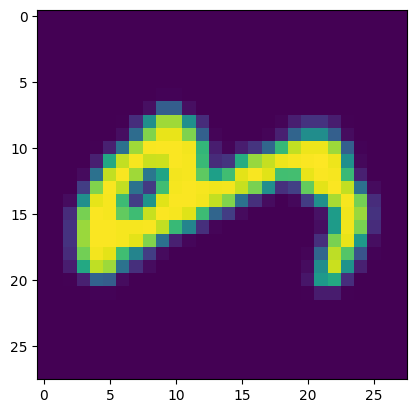

In [8]:
idx = 5
img = emnist_train.data[idx]
print("The digit shown is the letter: {}".format(emnist_dict[int(emnist_train.targets[idx])] ))
plt.imshow(img.to('cpu'))
plt.show()

## Deep Belief Network

In the following analysis the DBN model has a visible layer composed by 784 visible neurons.

The values in the script are:
- 28x28 is the number of visible units;
- There are 3 RBM hidden layers with respectively 350, 450 and 600 hidden neurons;
- K, a hyperparameter that indicates the number of iterations that the algorithm has to do befor stopping. K = 1 means that it is necessary only a recostruction of data to reach a good model;
- Learning rate determines the step size of gradient descent. If the learning rate is set too high, the convergence could be too fast and it could overshoot the optimum. On the other hand, if the learning rate chosen is a too low value, the process could be too slow. Learning rate decay is set to FALSE: it will not decrease;
- Momentum range 0.5 – 0.95: momentum adds a fraction of the previous weight update to the new one. If the gradient is in the same direction, the size of step taken towards the minimum will be increased. Momentum will flatten the variation when the gradient changes direction;
- Weight decay is a regularization tecnique used to force weights to spontaneously decay;
- Xavier Initialization won't be used;
- k is constant over the whole training;
- if available, a GPU is used.


In [9]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[350, 450, 600],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

## Training phase

During training, the network divides the data into batches at each epoch. Every 10 epochs, the reconstruction error is computed and displayed for each layer. This error quantifies the disparity between the original data and its reconstructed form. The reconstruction error diminishes as the number of epochs progresses, indicating improvement in the model's performance. The variables "mean_grad" and "std_grad" represent the magnitude and variability of the gradient, respectively. It is important for these values to strike a balance—neither excessively large nor overly small. This is because an optimal point must be reached, and while progress is necessary, an excessively substantial improvement might lead to overshooting the optimum. Therefore, maintaining an appropriate magnitude and variation in the gradient is crucial for achieving optimal results.

In [10]:
num_epochs = 50
batch_size = 125

dbn_emnist.train_static(emnist_train.data, emnist_train.targets, num_epochs, batch_size)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3682     |0.0457       |315.8710   |5.4282     |
|20    |1.3198     |0.0443       |304.3553   |5.1440     |
|30    |1.3056     |0.0423       |299.1442   |4.9346     |
|40    |1.2990     |0.0419       |296.8492   |4.6186     |
|50    |1.2965     |0.0410       |295.1382   |4.5319     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7394     |0.0455       |193.2694   |2.8842     |
|20    |1.6899     |0.0455       |190.2786   |2.5613     |
|30    |1.6775     |0.0461       |189.1306   |2.8401     |
|40    |1.6698     |0.0445       |188.1697   |2.6013     |
|50    |1.6710     |0.0457       |189.0930   |2.6754     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1950     |0.0345       |225.7540   |3.1864     |
|20    |1.1238     |0.0320       |210.2431   |3.002

## Visualization of receptive fields

Upon completing the network training, the next step is to visualize the learned weights. This visualization allows to gain insights into the patterns and features that trigger specific units within the network. To achieve this, we will plot a selection of weights in an image with the same dimensions as the EMNIST images used during training.
In order to reduce noise in the plots, a threshold to the weights is applied. Additionally, we scale all weight values uniformly to facilitate easier comparisons between different filters. We will represent the first 100 filters learned in each layer, providing a glimpse into the specific regions of an image or patterns that these individual nodes are capable of recognizing.
Since the dimensions of the second and third layers differ from the original 28x28 size, we need to project each layer onto a 28x28 dimensional space. This projection ensures that the visualized weights align properly with the original image dimensions, allowing for a more meaningful interpretation of the learned features.

In [11]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

In [12]:
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)))

In [13]:
def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

The result is a matrix composed by 100 receptive fields. Weights for layer 2 and layer 3 are obtained as dot product among weight matrices and new level matrix.

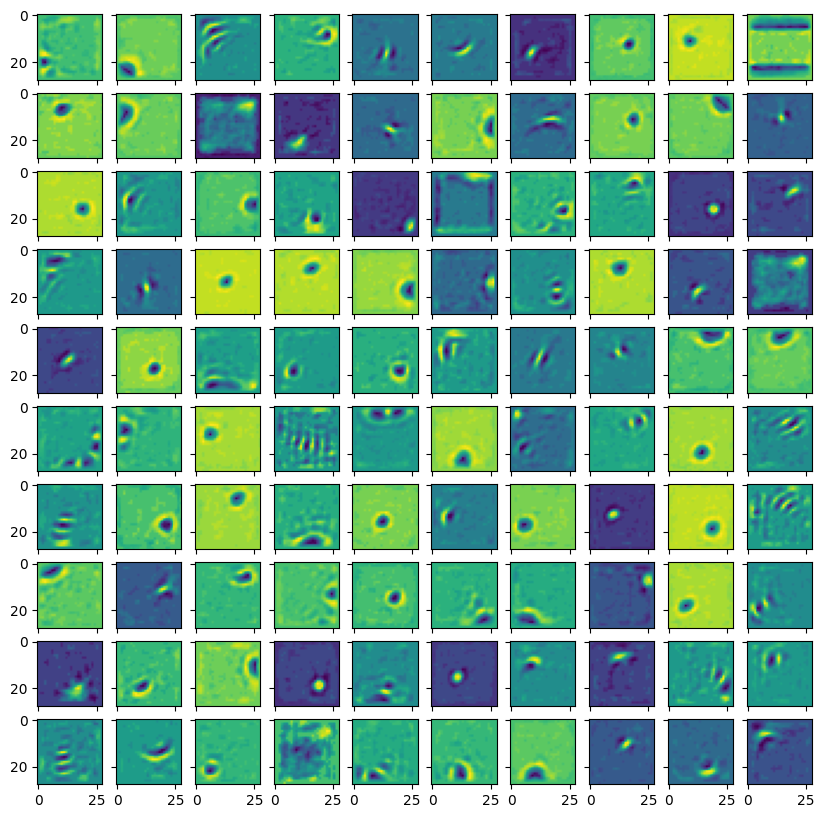

In [14]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

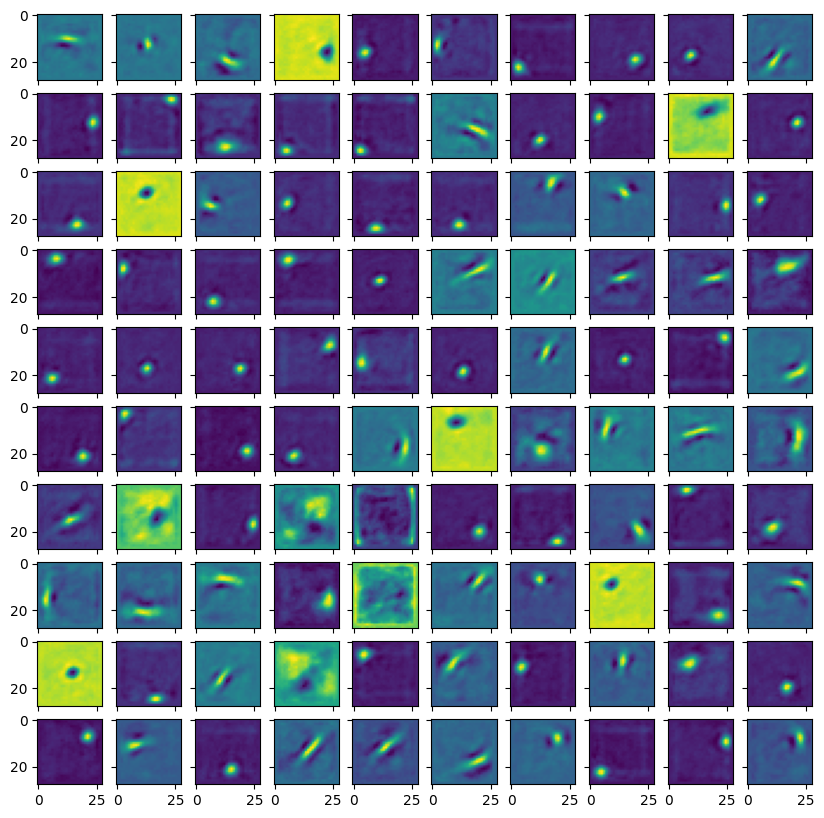

In [15]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

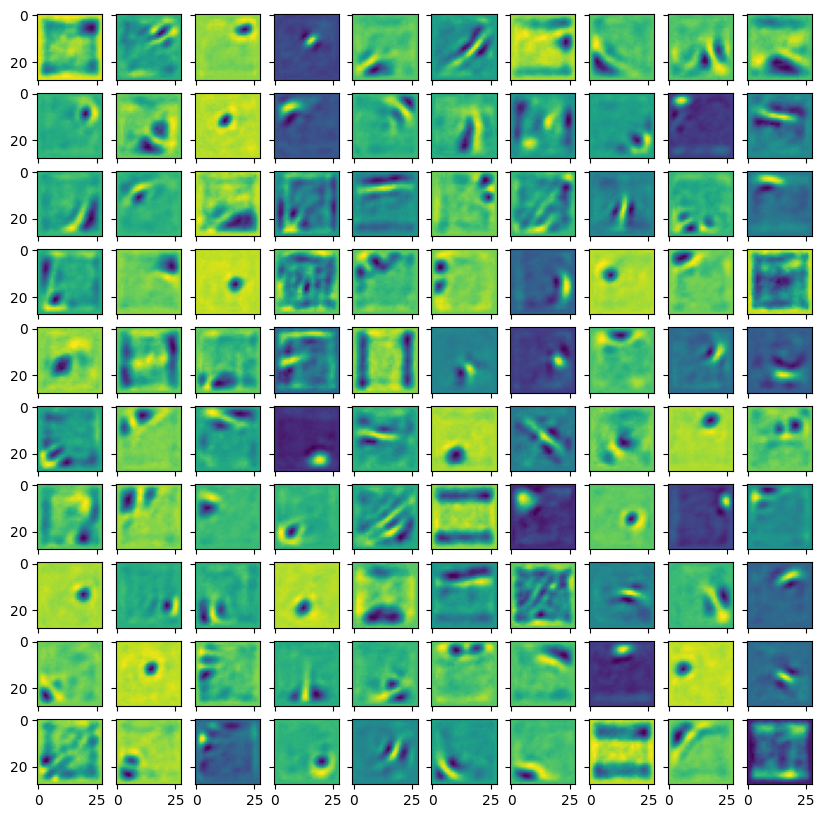

In [16]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

## Clustering internal representations

Next, we proceed to calculate the centroids of the learned representations for each class and assess their proximity to one another using a standard hierarchical clustering algorithm. The implemented Deep Belief Network (DBN) consists of multiple Restricted Boltzmann Machine (RBM) objects internally. Hence, to compute the hidden representations, we must utilize the weights of each RBM layer within the DBN.
Specifically, we calculate the representations of the second layer by utilizing the representations from the previous layer, and continue this process for subsequent layers. This stepwise computation ensures that each layer's hidden representation builds upon the information learned in the preceding layer. By leveraging these representations, we can analyze the proximity between different classes and gain insights into their relationships.

In [17]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

In [18]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

Now the aim is to calculate the average hidden representation for each class within the EMNIST dataset. This process involves constructing a matrix that contains all the necessary centroids. The resulting matrix will have dimensions of 26xD, where D represents the number of nodes in that particular layer.

Then we execute the clustering algorithm and visualize its output in a dendrogram plot. The dendrogram provides a comprehensive representation of how the data points are grouped into clusters at different levels. It is highly unlikely for one class to be mistaken for another if they are located far apart in the dendrogram.
We generate dendrograms for each of the three layers, showcasing the unique clusterings created by each layer based on the considered features. While the differences may not be immediately apparent due to the layout, a closer examination of the branches reveals distinctions. For instance, similar letters such as G and Q (or I and L, or F and P) consistently appear in close proximity to each other. However, there may be slight variations in the branching patterns around letters like W and M.

In [19]:
def get_mask(label):
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)
    for label in range(1, 27)
  }

def get_hidden_reprs_matrix(hidden_representation):
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)
    for label in range(1, 27)])

def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels = [emnist_dict[i+1] for i in range(26)])
  ax.set_title(title)

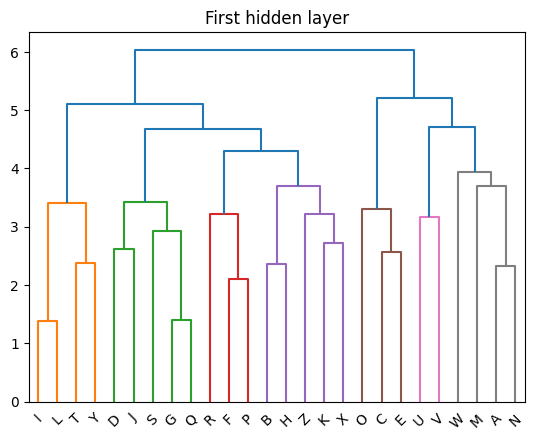

In [20]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

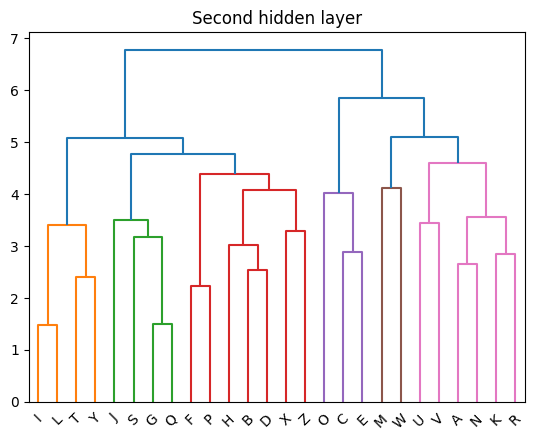

In [21]:
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

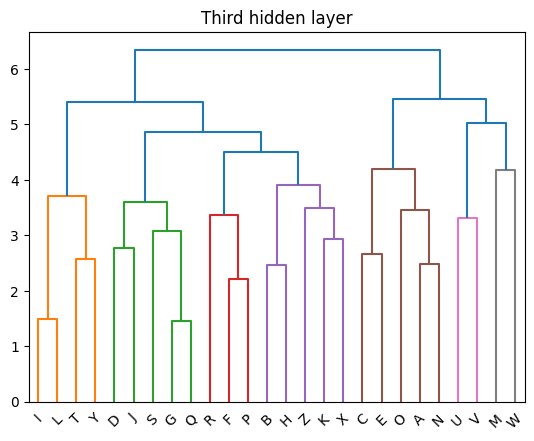

In [22]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

## Linear read-out: linear classifier model

A linear readout of the computed representations from each layer of the Deep Belief Network (DBN) is now performed. These representations are utilized for classifying the original images using a simple linear classifier, allowing us to evaluate the information content within each hidden representation. To accomplish this, a class is defined that includes a function responsible for linearly transforming the input tensor using a single fully connected layer.
The linear classifier is constructed to take the previously computed hidden representations from each layer as input, with the labels of the EMNIST dataset serving as the targets. Stochastic gradient descent is employed as the optimizer for this model, with calculations performed on a per-batch basis. Each linear layer is trained using this approach, and it becomes apparent that the loss (e.g., cross-entropy) decreases over epochs for each of the three layers.
If the decision is made to train the model for more epochs, the final loss would be smaller. However, to prevent overfitting and considering that the rate of improvement in loss decreases over time, it was decided to halt training after 1500 epochs. This decision balances the desire for better performance with the need to avoid overfitting the model to the training data.

In [23]:
class LinearModel(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 27)

  def forward(self, x):
    return self.linear(x)

In [24]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

## Linear classifier training phase on EMNIST letters

It is shown that the loss decreases as epochs increase: loss 1 goes from 3,3126 to 1,0101; loss 2 decreases from 3,3190 to 1,0125 and loss 3 passes from 3,3369 to 0,9336.

In [25]:
def train(model, input, epochs=1500):
  print_stride = 100 if epochs >= 1500 else 10
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  targets = emnist_train.targets

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(input)
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch: {:3d}/{} | loss: {:.4f}".format(epoch + 1, epochs, loss))

In [26]:
train(linear1, hidden_repr_layer_1, epochs=1500)
train(linear2, hidden_repr_layer_2, epochs=1500)
train(linear3, hidden_repr_layer_3, epochs=1500)

epoch:   1/1500 | loss: 3.3126
epoch: 101/1500 | loss: 2.2395
epoch: 201/1500 | loss: 1.7762
epoch: 301/1500 | loss: 1.5431
epoch: 401/1500 | loss: 1.4062
epoch: 501/1500 | loss: 1.3154
epoch: 601/1500 | loss: 1.2495
epoch: 701/1500 | loss: 1.1988
epoch: 801/1500 | loss: 1.1579
epoch: 901/1500 | loss: 1.1239
epoch: 1001/1500 | loss: 1.0949
epoch: 1101/1500 | loss: 1.0698
epoch: 1201/1500 | loss: 1.0477
epoch: 1301/1500 | loss: 1.0279
epoch: 1401/1500 | loss: 1.0101
epoch:   1/1500 | loss: 3.3190
epoch: 101/1500 | loss: 2.1685
epoch: 201/1500 | loss: 1.7197
epoch: 301/1500 | loss: 1.5053
epoch: 401/1500 | loss: 1.3809
epoch: 501/1500 | loss: 1.2981
epoch: 601/1500 | loss: 1.2375
epoch: 701/1500 | loss: 1.1905
epoch: 801/1500 | loss: 1.1524
epoch: 901/1500 | loss: 1.1205
epoch: 1001/1500 | loss: 1.0932
epoch: 1101/1500 | loss: 1.0694
epoch: 1201/1500 | loss: 1.0484
epoch: 1301/1500 | loss: 1.0295
epoch: 1401/1500 | loss: 1.0125
epoch:   1/1500 | loss: 3.3369
epoch: 101/1500 | loss: 2.168

# Linear classifier testing phase

Next, the test set: the hidden representations of the three layers are computed for this test set. These representations capture the learned features and patterns within the DBN. Subsequently, predictions are made using the previously trained linear model.
To evaluate the performance of the linear model and determine if it effectively classifies the test set, an accuracy score is computed. Accuracy represents the number of correct predictions divided by the total number of predictions. It is used to understand how well neurons encode hidden data. In order to compute the accuracy of the model it is necessary to obtain the hidden representation of RBM hidden layers, such that they can be used for predictions and accuracy estimation.
The obtained accuracy scores for all three layers are approximately 0.7. This value indicates that a significant proportion of the predictions made by the linear model were correct.

As it can be seen,  the last layer gives a better accuracy. It means that increasing the complexity of the model allows the model to achieve better performance.

In [27]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [28]:
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [29]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [30]:
compute_accuracy(predictions_test1, emnist_test.targets)

0.7249519228935242

In [31]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.7187981009483337

In [32]:
compute_accuracy(predictions_test3, emnist_test.targets)

0.7455769181251526

Confusion matrices

Confusion matrices allows to visualize the porformance of the model. Diagonal elements represent the sum of well-predicted labels related to a specific class. The third confusion matrix has the highest well-predicted amount of elements. According with the results reached computing accuracies, the confusion matrix of the third layer shows that the third layer is more accurate and it can recognize a higher amount of instances than the first and second layers.

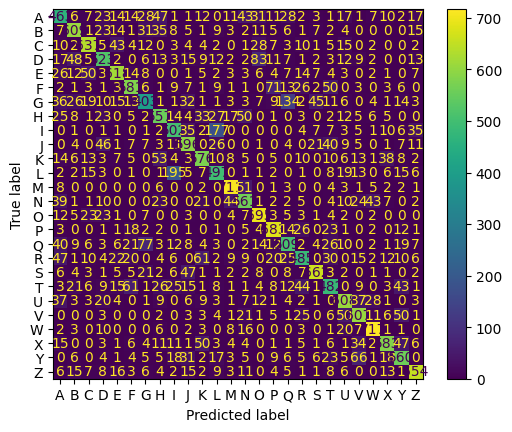

In [33]:
from sklearn import metrics
classes=["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
y_preds = np.argmax((linear1(hidden_repr_layer_1_test)).cpu().data.numpy(), axis=-1)
y_targ = emnist_test.targets
cm = metrics.confusion_matrix(y_targ.cpu().numpy(), y_preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
disp.plot()
plt.show()

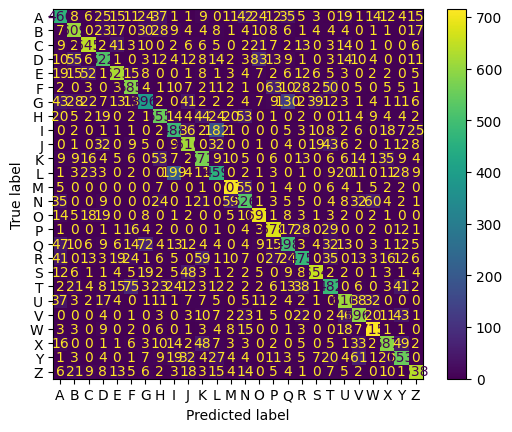

In [34]:
from sklearn import metrics
classes=["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
y_preds = np.argmax((linear2(hidden_repr_layer_2_test)).cpu().data.numpy(), axis=-1)
y_targ = emnist_test.targets
cm = metrics.confusion_matrix(y_targ.cpu().numpy(), y_preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
disp.plot()
plt.show()

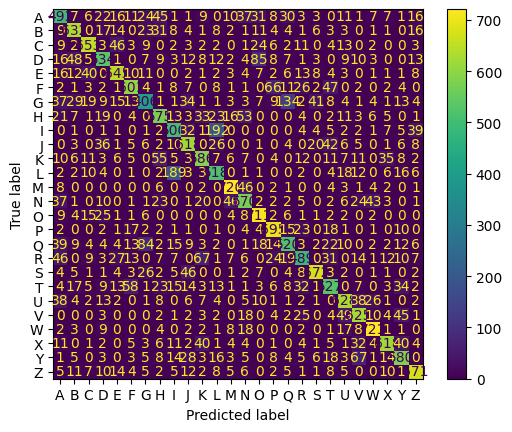

In [35]:
from sklearn import metrics
classes=["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
y_preds = np.argmax((linear3(hidden_repr_layer_3_test)).cpu().data.numpy(), axis=-1)
y_targ = emnist_test.targets
cm = metrics.confusion_matrix(y_targ.cpu().numpy(), y_preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
disp.plot()
plt.show()

## Feed Forward

To compare the performance of a non-linear, end-to-end trained model and a simple linear classifier that uses unsupervised learned representations, a feed-forward neural network with the same structure as the Deep Belief Network (DBN) was trained. The objective was to solve a classification task.
The feed-forward network consists of three layers. The first layer takes an input size of 784, which corresponds to the number of pixels in an EMNIST image. The training procedure and the number of epochs used were kept consistent, and the number of nodes in each hidden layer is 350, 450 and 600 as before (in order to have a fair comparison between the two models and the three RBMs). The output layer is composed by 27 neurons.
To prevent the issue of gradient vanishing, each hidden unit in the network employs the rectified linear unit (ReLU) activation function. ReLU is a non-linear function that operates on the global input of each hidden unit. It helps mitigate the problem of vanishing gradients that can occur during training. By using ReLU, the network aims to preserve the gradient flow and enable effective learning and optimization.

In [36]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 27)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [37]:
ffnn = Feedforward(350, 450, 600).to(device)

Feed-forward model on EMNIST letters: training phase

Loss decreases from 3.2952 to 0,8384 as epochs increase.

In [38]:
train(ffnn, emnist_train.data.reshape((124800, 784)), epochs=1500)

epoch:   1/1500 | loss: 3.2952
epoch: 101/1500 | loss: 3.2557
epoch: 201/1500 | loss: 3.1207
epoch: 301/1500 | loss: 2.4333
epoch: 401/1500 | loss: 1.7978
epoch: 501/1500 | loss: 1.5241
epoch: 601/1500 | loss: 1.3804
epoch: 701/1500 | loss: 1.2718
epoch: 801/1500 | loss: 1.2065
epoch: 901/1500 | loss: 1.1117
epoch: 1001/1500 | loss: 1.0481
epoch: 1101/1500 | loss: 0.9895
epoch: 1201/1500 | loss: 0.9353
epoch: 1301/1500 | loss: 0.8848
epoch: 1401/1500 | loss: 0.8384


Feed-forward model on EMNIST letters: testing phase

In [39]:
predictions_ffnn = ffnn(emnist_test.data.reshape((20800, 784)))

The accuracy is a bit higher than the accuracy level of the third hidden layer classifier, but there is a very small difference (0,0227).

In [40]:
compute_accuracy(predictions_ffnn, emnist_test.targets)

0.7683172821998596

## Psychometric curves: robustness to noise

The following code has been used to analyze the level of the model accuracy in prediction of distorted data. First of all, it has been injected a noise on the test sample. The noise has been firstly introducted to each instance randomly following a gaussian distribution. The computed value is multiplied by the noise level, which serves as an indicator of the variance of the Gaussian distribution. The expected result is that accuracy should decrease as noise increases.

In [41]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)

  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)

  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

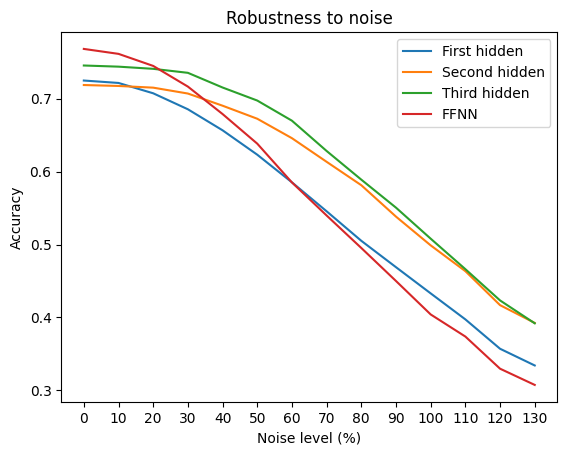

In [42]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

It can be seen that DNN is the worst model in terms of robustness. It still is the best model until noise level gets greater or equal to 0.2. Second and third hidden layers show better robustness, in fact with a noise level equal to 1.3, their accuracy value is around 40%. As shown in the chart, the third hidden layer is more accurate than the second hidden layer for higher level of noise. The reason could be the risk of overfitting of the third layer.

## Adversarial attacks

Adversarial attacks aim to manipulate the input in a way that the model becomes unable to correctly classify it, resulting in an increased loss for that specific input. The loss function typically takes into account the input, the model's parameters, and the model's outputs.
During model training, the weights are adjusted based on the gradient of the loss function, moving in the opposite direction to decrease the loss. However, when creating an adversarial sample, instead of modifying the model's weights, it is altered the input itself. In this case, it is followed the same direction as the gradient, intentionally increasing the loss function.
The objective of such modifications is to deceive the model and exploit its vulnerabilities, causing misclassification or inducing false outputs. By understanding the gradient's direction, adversaries can manipulate inputs strategically to trigger specific responses from the model, leading to compromised performance.

The first step is to modify DBN model to simulate back propagation and to show how the DBN would react to an adversarial attack.

In [43]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

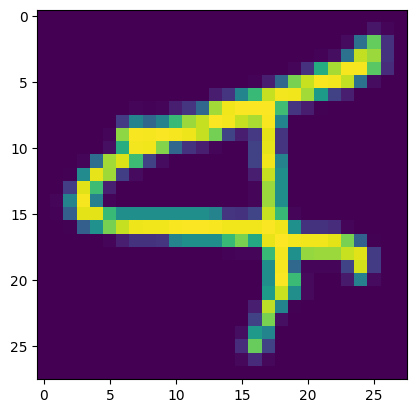

In [46]:
test_sample_idx = 4
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

DBN With ReadOut: robustness

 A read-out classifier is introduced, utilizing the previously defined DBN classifier. The pre-trained linear classifiers within the DBN are employed to generate the final prediction by leveraging the DBN as a feature extractor. In this specific scenario, the third layer of the DBN functions as the read-out layer during the inference process. With the assistance of backpropagation, this model can be conveniently fine-tuned to cater to specific requirements or optimize performance based on desired outcomes.

In [47]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [48]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

Resisting to adversarial attacks

In [49]:
def test_dbn_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True

        output = dbn_with_readout.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        dbn_with_readout.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = dbn_with_readout.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        output = dbn_with_readout(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

Testing DBN with ReadOut: without reconstruction of data

In [50]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('https://github.com/aurelienduarte/emnist', train=False, download=False, split = 'letters', transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [51]:
final_acc = test_dbn_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon=0.1, num_steps= 0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 53.53%



Testing DBN with ReadOut: with reconstruction of data

  0%|          | 0/208 [00:00<?, ?it/s]


Here's the original sample:



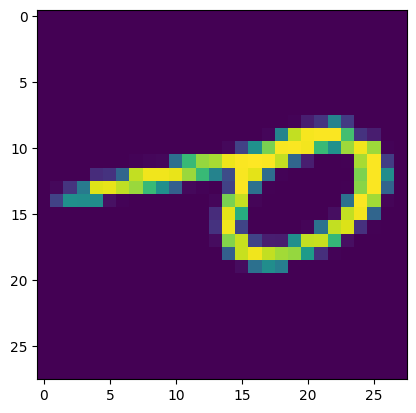


Here's a perturbed sample:



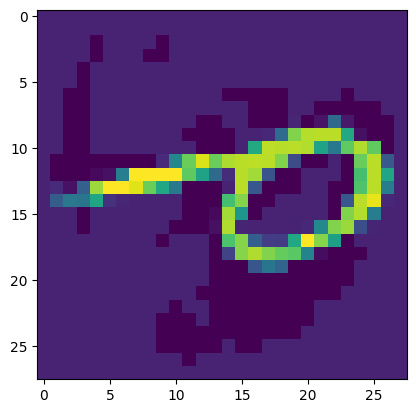


Here's what a 1-steps reconstructed sample looks like:



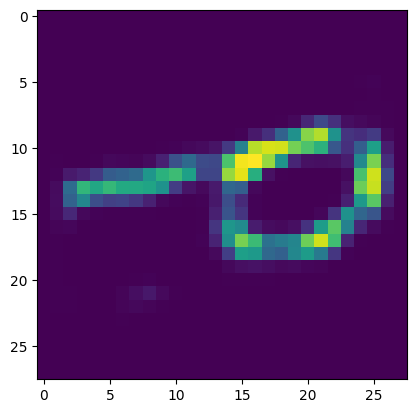


Epsilon: 0.1
Test Accuracy: 58.26%



In [52]:
final_acc = test_dbn_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon=0.1, num_steps= 1)

DNN model: robustness

In [53]:
def test_dnn_robustness_to_attack(device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True

        output = ffnn.forward(data)

        init_pred = torch.argmax(output)




        loss = functional.nll_loss(output, target)
        ffnn.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)




        output = ffnn(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [54]:
final_acc = test_dnn_robustness_to_attack(device, test_loader, epsilon=0.1)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 24.35%



## Effect of the noise parameter  epsilon

Next, the robustness of each of the three models is evaluated by subjecting them to increasingly stronger attacks. The FFN consistently performs worse than the DBN in both reconstructed and unaltered states. These results clearly demonstrate the DBN's superior accuracy in tackling such challenges.
However, even without the reconstruction capability, the DBN's performance remains notably superior to that of the FFN.

In [55]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

In [56]:

    accuracies_dbn = list()
    accuracies_dbn_rec = list()
    accuracies_dnn = list()

    for eps in epsilon_values:
      acc_dbn = test_dbn_robustness_to_attack(dbn_with_readout, device, test_loader, eps, num_steps=0, verbose=False)
      accuracies_dbn.append(acc_dbn)
      acc_dbn_rec = test_dbn_robustness_to_attack(dbn_with_readout, device, test_loader, eps, num_steps=1, verbose=False)
      accuracies_dbn_rec.append(acc_dbn_rec)
      acc_dnn = test_dnn_robustness_to_attack(device, test_loader, eps, verbose=False)
      accuracies_dnn.append(acc_dnn)


  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0
Test Accuracy: 74.56%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0
Test Accuracy: 74.13%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0
Test Accuracy: 76.83%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.05
Test Accuracy: 65.47%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.05
Test Accuracy: 66.24%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.05
Test Accuracy: 54.23%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 53.53%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 58.26%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 24.35%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.15
Test Accuracy: 36.65%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.15
Test Accuracy: 46.89%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.15
Test Accuracy: 6.70%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 21.18%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 31.18%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 1.43%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.25
Test Accuracy: 11.07%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.25
Test Accuracy: 17.74%



  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.25
Test Accuracy: 0.31%



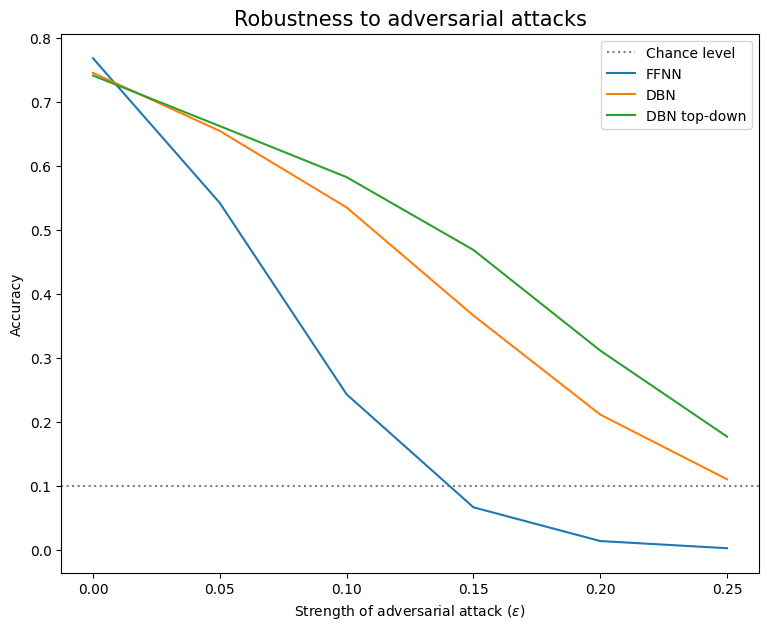

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_dnn)
__ = ax.plot(epsilon_values, accuracies_dbn)
__ = ax.plot(epsilon_values, accuracies_dbn_rec)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

The chart shows that even few value of the strength of avversarial attack could create a high loss of model accuracy. While the DNN accuracy decreases for small values of epsilon, DBN keeps a quite good level of accuracy (around 0.4) for epsilon values smaller than 0.15, than the accuracy loss for the DBN bacomes higher. DBN top-down iterated more times could reduce the presence of the noise. So, DBN model can remove injected attacks, infact with only 1 step the performance increases.

In comparison to an FFN (Feed-Forward Neural Network), the DBN consistently outperformed in all the tested scenarios. This emphasizes the DBN's exceptional performance when attempting to simulate human perception.
Despite applying small amounts of noise and subjecting the images to attacks, these challenges posed no significant obstacle for a human observer, who would effortlessly distinguish them. However, for a neural network, such tasks are not as trivial. The experiments demonstrated that the DBN stands out as a promising choice when aiming to develop an algorithm that can "simulate" our perception to a certain extent.